In [2]:
from fit import MF
from dataloader import PointCloudDataloader
import torch
from helpers import DQ,ScalerBase,LogitTransformer
model=MF.load_from_checkpoint("/beegfs/desy/user/kaechben/calochallenge/CaloChallenge/x00n6q7f/checkpoints/epoch=612-w1p=0.00067-E=0.0000934.ckpt")
#big
#modelbig=MF.load_from_checkpoint("/beegfs/desy/user/schnakes/calochallenge/CaloChallenge/lfbzcvva/checkpoints/epoch=183-w1p=0.00271.ckpt")

dl=PointCloudDataloader(name="middle",batch_size=1024,max=False,scaled=False)
#dl_big=PointCloudDataloader(name="big",batch_size=1024)

dl.setup("train")

In [5]:
#middle
#model=MF.load_from_checkpoint("/beegfs/desy/user/schnakes/calochallenge/CaloChallenge/ibacllj4/checkpoints/epoch=334-w1p=0.00099.ckpt")

#dl_big.setup("validation")
model.min_E=10
for i in (dl.train_dataloader()):
    batch,mask,_=i[0],i[1],i[2]
    batch[mask.bool()]=0
    if batch[:, :, 0].min() < model.min_E:
                model.min_E = batch[:, :, 0].min()
print(model.min_E)


tensor(-3.3306)


In [19]:
middle=[]
model.load_datamodule(dl)
voxel_shape=(45,16,9)
c=0
g=0
Es=[]
pc_real=[]
pc_fake=[]
with torch.no_grad():
    for i in dl.val_dataloader():
        with torch.no_grad():
            cond=i[2]
            pc_real.append(i[0])
            
            E=(cond+10).clone().exp()
            cond=torch.cat((cond.reshape(-1,1),(~i[1]).float().sum(1).reshape(-1,1)),dim=-1).float()
            x=model.sampleandscale(i[0],mask=i[1].bool(),cond=cond,scale=True)
            pc_fake.append(x)
            voxel_tensor=torch.zeros((len(i[0]),*voxel_shape)).clone()
            E_tensor=torch.zeros((len(i[0]))).clone()
            for _,k in enumerate(x):
                values=k[:,0]
                indices=k[:,1:]
                g+=len(k)
                torch.clamp(indices[:,0],0,voxel_shape[0]-1,out=indices[:,0])
                torch.clamp(indices[:,1],0,voxel_shape[1]-1,out=indices[:,1])
                torch.clamp(indices[:,2],0,voxel_shape[2]-1,out=indices[:,2])
            
                indices=indices[values>0]
                values=values[values>0]
                counts=indices.unique()[1].max()
                # print(indices,values)
                if counts>1:
                    c+=counts.sum()
                
                voxel_tensor[_]=torch.sparse_coo_tensor(indices=indices.T,values=values,size=voxel_shape).coalesce().to_dense()
            E_tensor=E
            middle.append(voxel_tensor)
            Es.append(E_tensor)  

scaler values: 2.056966213845739 3.0621282017453395 0.04883541887735249


In [7]:
import h5py
import numpy as np
middle_=torch.vstack(middle).reshape(-1,voxel_shape[0]*voxel_shape[1]*voxel_shape[2]).numpy()
E=torch.hstack(Es)
with h5py.File("middle_best_w1p.hdf5", "w") as h5_file:
    
    N = len(middle_) # find the length of my dataset
    h5_file.create_dataset('incident_energies', shape=(N, ), dtype=np.float32, data=E.numpy())
    h5_file.create_dataset('showers', shape=(N,voxel_shape[0]*voxel_shape[1]*voxel_shape[2] ), dtype=np.float32, data=middle_)

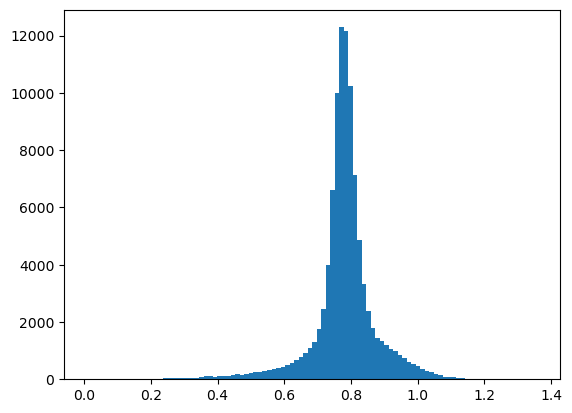

In [18]:
import matplotlib.pyplot as plt
plt.hist(middle_.reshape(-1,voxel_shape[0],voxel_shape[1],voxel_shape[2])[:,:,:,:].sum(3).sum(2).sum(1)/E.numpy(),bins=100);
# plt.yscale("log")

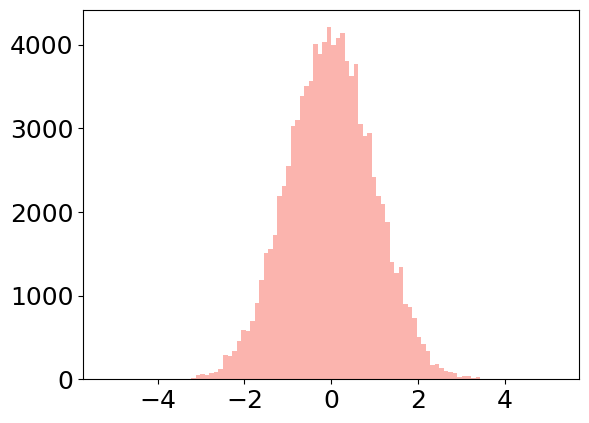

In [20]:
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler,StandardScaler
plt.hist(QuantileTransformer(output_distribution="normal").fit_transform(E.numpy().reshape(-1,1)),bins=100);

/beegfs/desy/user/kaechben/.conda/envs/torch_jet/lib/python3.10/site-packages/pytorch_lightning/core/module.py:410: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
Traceback (most recent call last):
  File "/home/kaechben/CaloChallenge/fit.py", line 329, in on_validation_epoch_end
    self.plot.plot_ratio(self.hists_fake, self.hists_real, weighted=False)
  File "/home/kaechben/CaloChallenge/helpers.py", line 298, in plot_ratio
    self.summary.log_image("{}ratio".format("weighted " if weighted else "unweighted "), [fig],self.step)
AttributeError: 'NoneType' object has no attribute 'log_image'


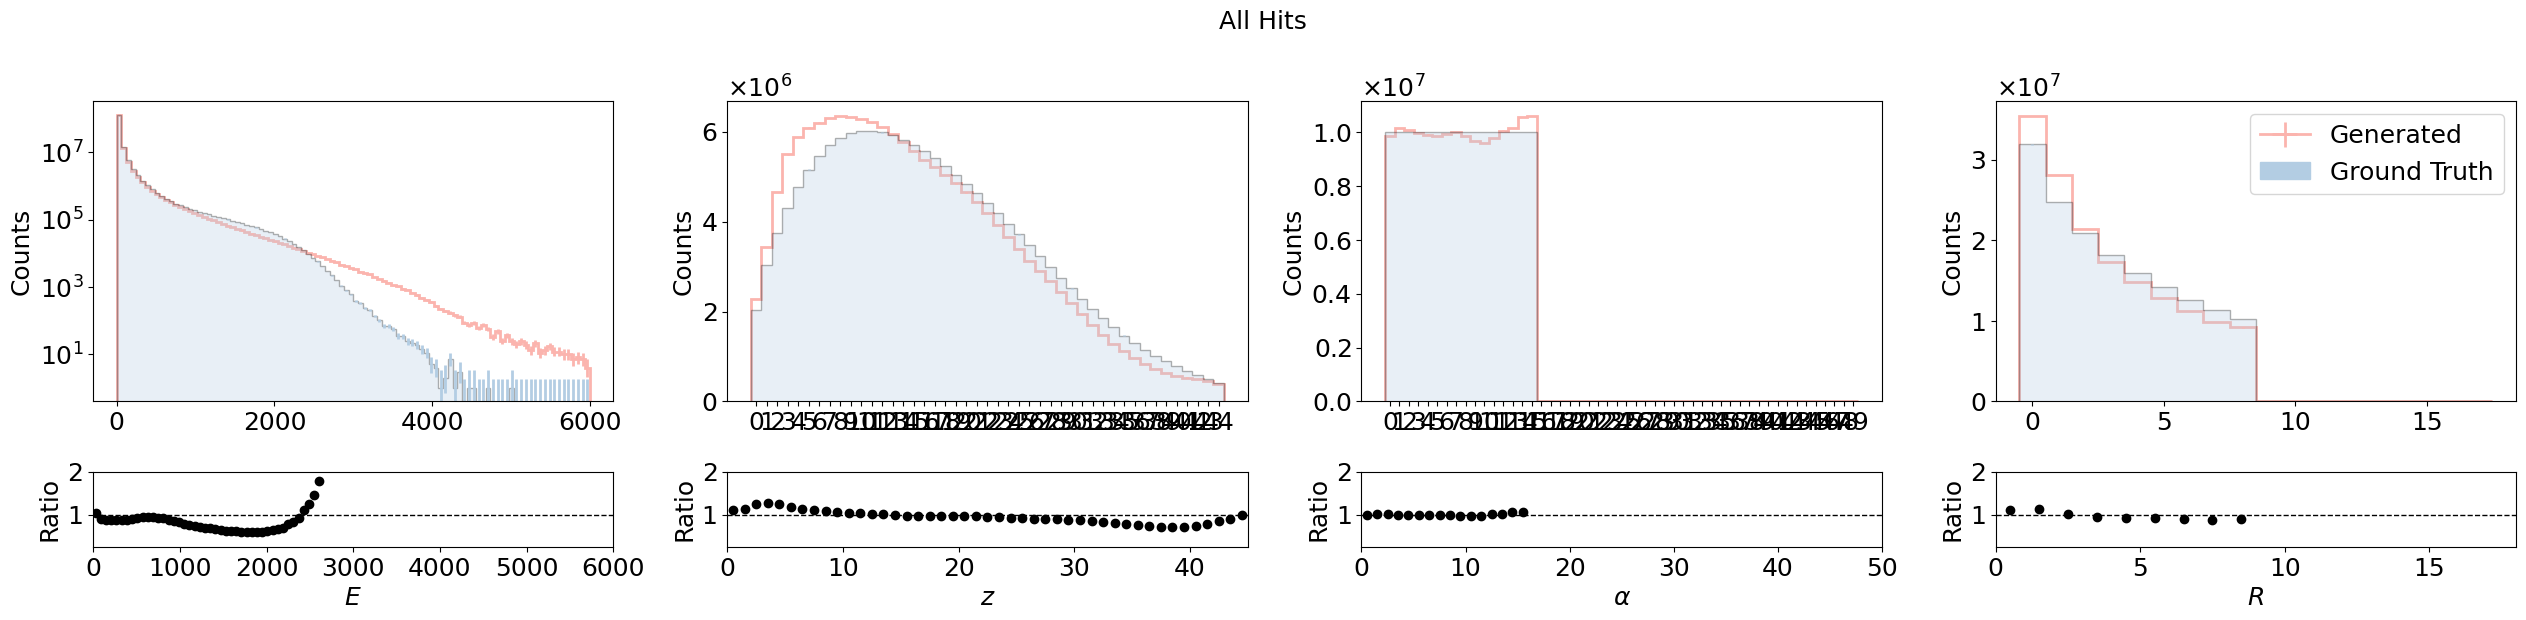

In [5]:
model.on_validation_epoch_start()
for i in dl.val_dataloader():
    model.validation_step(i,0)
model.on_validation_epoch_end()

In [6]:
E.min()
batch,mask,cond=i[0],i[1],i[2]
cond1000=(torch.ones_like(batch[:,0,:1])*1000).log()-10
cond10000=(torch.ones_like(batch[:,0,:1])*10000).log()-10
cond100000=(torch.ones_like(batch[:,0,:1])*100000).log()-10
cond1000 = torch.cat((cond1000.reshape(-1, 1), (~i[1]).float().sum(1).reshape(-1, 1)), dim=-1).float()
cond10000 = torch.cat((cond10000.reshape(-1, 1), (~i[1]).float().sum(1).reshape(-1, 1)), dim=-1).float()
cond100000 = torch.cat((cond100000.reshape(-1, 1), (~i[1]).float().sum(1).reshape(-1, 1)), dim=-1).float()
E1000=model.sampleandscale(batch=i[0],mask=i[1].bool(),cond=cond1000,scale=True)
E10000=model.sampleandscale(batch=i[0],mask=i[1].bool(),cond=cond10000,scale=True)
E100000=model.sampleandscale(batch=i[0],mask=i[1].bool(),cond=cond100000,scale=True)



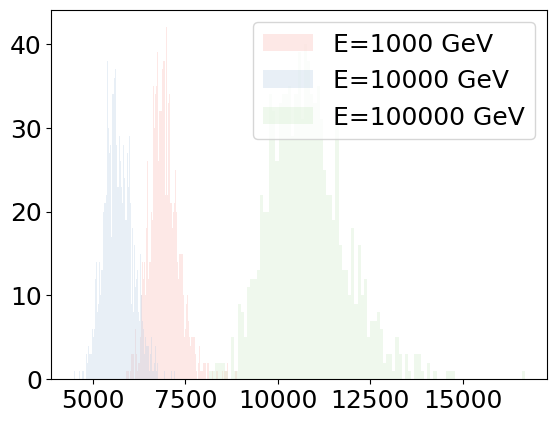

In [7]:
import matplotlib.pyplot as plt
plt.hist(E1000[:,:,0].sum(1).detach().numpy(),bins=100,label="E=1000 GeV",alpha=0.3);
plt.hist(E10000[:,:,0].sum(1).detach().numpy(),bins=100,label="E=10000 GeV",alpha=0.3);
plt.hist(E100000[:,:,0].sum(1).detach().numpy(),bins=100,label="E=100000 GeV",alpha=0.3);
plt.legend()

In [14]:
cond1000.shape

torch.Size([512, 1])

In [8]:
with h5py.File("middle_E_best.hdf5", "r") as h5_file:
    print(h5_file.keys())
    print(h5_file['showers'].shape)
    print(h5_file['incident_energies'].shape)
    print(h5_file['showers'][0])
    print(h5_file['incident_energies'][0])
    print(h5_file['showers'][0].reshape(45,16,9))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'middle_E_best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [24]:
middle_[:10]

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [8.585953, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)